# Topic Modelling

**Goals**

- Can the reviews be classified according to emergent topics? (e.g., can review j be made up of 0.5 topic “service; speed; sympathy”, and 0.3 topic “ambiance; decoration; furniture”?)

- What do the emergent topics  mean?  (i.e.,  are  they  meaningful  regarding  the  project’s context?) 

- Can relevant insights be extracted from the topics?

## 1. Imports

In [2]:
import numpy as np
import pandas as pd
import regex as re
import sys, os

# Custom Imports
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'utils')))
import pipeline as p
from pipeline import MainPipeline
import preproc as pp
import visualizations as v

#Preprocessing
from nltk.tokenize import word_tokenize
from nltk.tokenize import PunktSentenceTokenizer
from textblob import TextBlob
sent_tokenizer = PunktSentenceTokenizer()

#Vectorization
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

#Classification and Metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn import metrics
from bertopic import BERTopic
from umap import UMAP
from sklearn.decomposition import LatentDirichletAllocation

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from tqdm import tqdm

c:\Users\msard\anaconda3\envs\textmining\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [42]:
# Load the dataset
reviews = pd.read_csv('../data_hyderabad/10k_reviews.csv')

## 2. Preprocessing

Basic preprocessing on the review text. Includes removal of the words that were appearing most often in all topics, to make the topics more interpretable.

In [43]:
reviews.dropna(subset=['Review'], inplace=True)

# Applying the pipeline
preprocessor = MainPipeline(custom_stopwords=['good', 'place', 'food', 'hhsjoibohoogogigivigigugihohohohphpjpjpjjohohohohohohohohohohojojojpjpjpjohpjpjohohohohhjohojpjojohohohohohhohohohojojojojohohohigufufyfyfufufugkbkhkhkgigkghighihhohohih'])
reviews['Preproc_Review'] = preprocessor.transform(reviews['Review'])

In [44]:
# Simple vectorization with Bag of Words
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X = vectorizer.fit_transform(reviews['Preproc_Review'])

## 3. Topic Modelling

We'll use Latent Dirichlet Allocation and BERT

### 3.1. Latent Dirichlet Allocation

In [45]:
n_topics = 10  # Number of topics
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda.fit(X)

LatentDirichletAllocation(random_state=42)

In [46]:
def get_top_words(model, feature_names, no_top_words):
    '''
    Extract most common n words for each topic
    '''
    top_words_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        top_words_dict[topic_idx] = " ".join(top_words)
    return top_words_dict

# Get the top words for each topic
no_top_words = 5
tf_feature_names = vectorizer.get_feature_names_out()
top_words_dict = get_top_words(lda, tf_feature_names, no_top_words)

In [47]:
def display_topics(model, feature_names, no_top_words):
    '''
    Format the printing of the topics
    '''
    for i, topic in enumerate(model.components_):
        print(f"Topic {i}:")
        print(" ".join([feature_names[j] for j in topic.argsort()[ : -no_top_words-1 : -1]]))
        
display_topics(lda, tf_feature_names, no_top_words)

Topic 0:
chicken biryani veg taste try
Topic 1:
cake taste chocolate quantity order
Topic 2:
service bad serve order ask
Topic 3:
order time paneer restaurant deliver
Topic 4:
biryani taste delivery bad order
Topic 5:
ambience service nice great best
Topic 6:
service great staff visit ambience
Topic 7:
burger chicken pizza like cheese
Topic 8:
chicken order taste rice fry
Topic 9:
really love best amaze try


In [48]:
# Assign topic names to reviews
topic_distribution = lda.transform(X)

reviews['Topics_LDA'] = topic_distribution.tolist()

#### 3.1.1. Visualizations

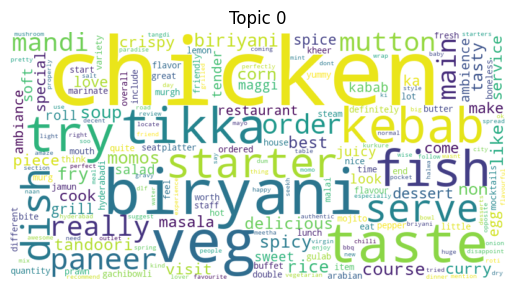

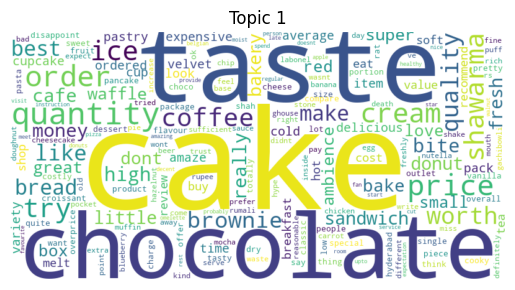

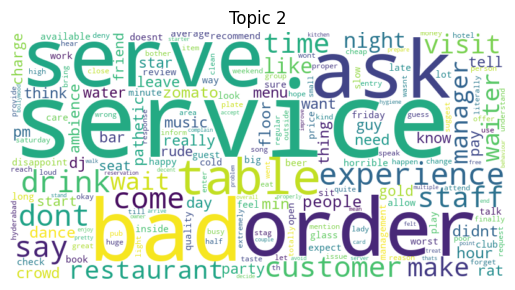

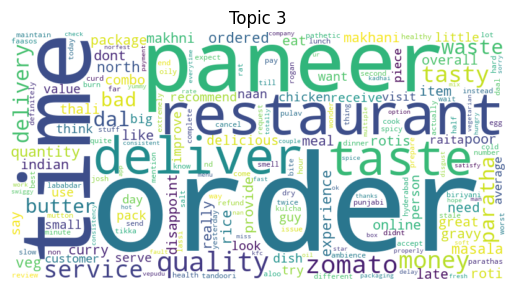

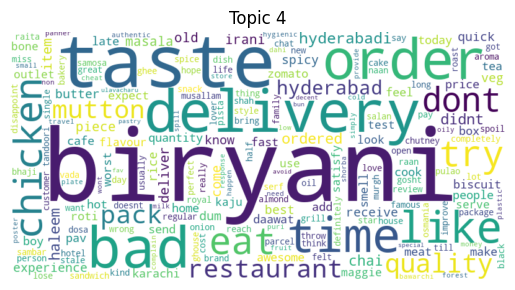

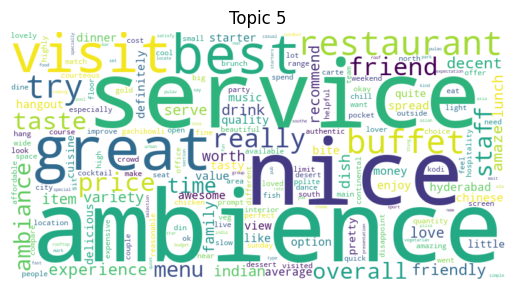

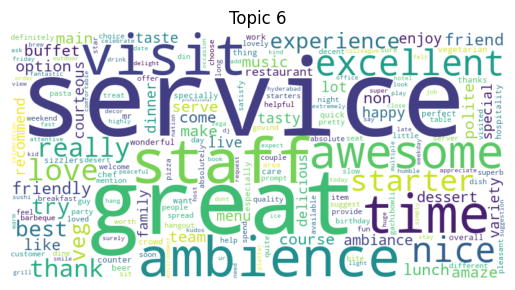

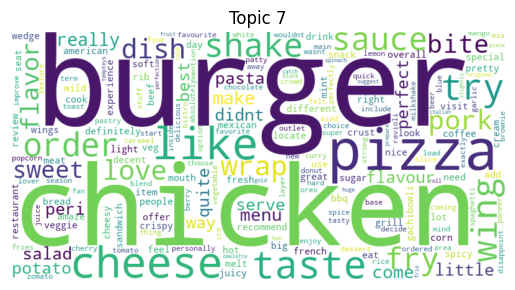

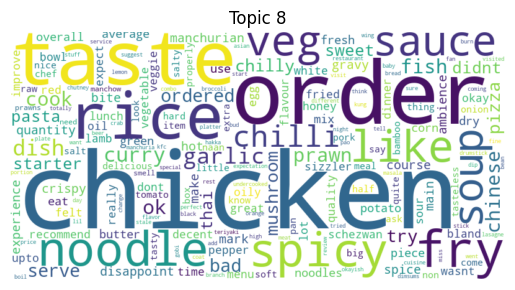

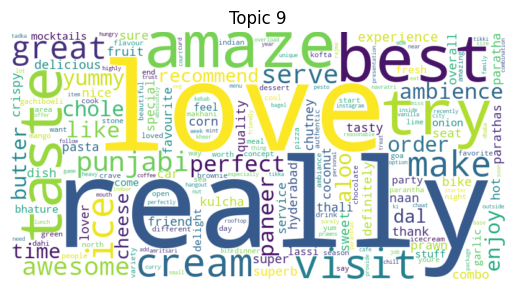

In [49]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np

feature_names = np.array(vectorizer.get_feature_names_out())

for topic_idx, topic in enumerate(lda.components_):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(zip(feature_names, topic)))
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Topic {topic_idx}")
    plt.show()

In [50]:
# Step 2: Import necessary libraries
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from gensim import corpora
import gensim

# Step 3: Prepare the data for visualization
# Convert the document-term matrix to a Gensim corpus
corpus = [vectorizer.transform([text]).toarray()[0] for text in reviews['Preproc_Review']]
corpus = [list(zip(range(len(doc)), doc)) for doc in corpus]

# Create a Gensim dictionary from the vectorizer's feature names
id2word = corpora.Dictionary([vectorizer.get_feature_names_out()])

# Convert the LDA model to Gensim format
gensim_lda = gensim.models.ldamodel.LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=n_topics,
    random_state=42
)

# Step 4: Generate and display the visualization
lda_vis_data = gensimvis.prepare(gensim_lda, corpus, id2word)
# Step 5: Save the visualization to an HTML file
pyLDAvis.save_html(lda_vis_data, 'lda_visualization.html')

### 3.2. BERTopic

In [14]:
# Initiate UMAP
umap_model = UMAP(n_neighbors=15, 
                  n_components=5, 
                  min_dist=0.0, 
                  metric='cosine', 
                  random_state=100)

# Initiate BERTopic
topic_model = BERTopic(umap_model=umap_model, language="english", calculate_probabilities=True)

# Run BERTopic model
topics, probabilities = topic_model.fit_transform(reviews['Preproc_Review'])

In [ ]:
# Get the list of topics
topic_model.get_topic_info()

Topic  Count                                               Name  \
0       -1   4796                  -1_ambience_service_order_chicken   
1        0    407  0_goo_weast_hhsjoibohoogogigivigigugihohohohph...   
2        1    379                   1_biryani_biriyani_chicken_piece   
3        2    213                        2_rude_manager_customer_ask   
4        3    181                  3_excellent_service_govind_shivam   
..     ...    ...                                                ...   
123    122     11                           122_steak_pasta_cube_kid   
124    123     11                      123_pork_barbeque_drunch_main   
125    124     10                     124_south_indian_iddli_laddoos   
126    125     10                   125_pack_quantity_cello_evrytime   
127    126     10                      126_awsome_ranvir_smily_mukul   

                                        Representation  \
0    [ambience, service, order, chicken, taste, gre...   
1    [goo, weast, hhsjoibohoogogigivigigugihohohohp...   
2    [biryani, biriyani, chicken, piece, mutton, du...   
3    [rude, manager, customer, ask, bad, worst, bil...   
4    [excellent, service, govind, shivam, thank, ba...   
..                                                 ...   
123  [steak, pasta, cube, kid, alfredo, pizza, dece...   
124  [pork, barbeque, drunch, main, corn, veg, incl...   
125  [south, indian, iddli, laddoos, floppy, cowmil...   
126  [pack, quantity, cello, evrytime, downppl, par...   
127  [awsome, ranvir, smily, mukul, uttam, ummm, am...   

                                   Representative_Docs  
0    [close house sln terminus one often visit seri...  
1    [hhsjoibohoogogigivigigugihohohohphpjpjpjjohoh...  
2    [dont like biryani worst biryani taste doesnt ...  
3    [ulavacharu well know taste service receive to...  
4    [excellent excellent service bahadur fully hap...  
..                                                 ...  
123  [bistro dinner friend recently weekday ambienc...  
124  [invite mr srinivas man charge aww taste lunch...  
125  [affordable restaurant delicious south indian ...  
126  [essence paratha go paratha go yr margin low p...  
127  [amazing tikki must try dahi ki kaloti ummm gr...  

[128 rows x 5 columns]

In [16]:
# Get top 10 terms for a topic
topic_model.get_topic(0)

[('goo', 0.750280947599631),
 ('weast', 0.5046618436828435),
 ('hhsjoibohoogogigivigigugihohohohphpjpjpjjohohohohohohohohohohojojojpjpjpjohpjpjohohohohhjohojpjojohohohohohhohohohojojojojohohohigufufyfyfufufugkbkhkhkgigkghighihhohohih',
  0.5046618436828435),
 ('bhehave', 0.5046618436828435),
 ('gooood', 0.4584864047664952),
 ('excelent', 0.4584864047664952),
 ('tast', 0.4123452858487586),
 ('goood', 0.3853829010528219),
 ('verry', 0.33937853345131946),
 ('upto', 0.19494257469113213)]

In [ ]:
# Visualize top topic keywords
topic_model.visualize_barchart(top_n_topics=12)

In [ ]:
# Visualize term rank decrease
topic_model.visualize_term_rank()

In [ ]:
# Visualize intertopic distance
topic_model.visualize_topics()

In [22]:
reviews.reset_index(drop=True, inplace=True)
topic_model.visualize_documents(reviews['Preproc_Review'])
# This uses UMAP to reduce the dimensions to 2D

In [ ]:
# Visualize connections between topics using hierachical clustering
topic_model.visualize_hierarchy()

In [ ]:
# Visualize similarity using heatmap
topic_model.visualize_heatmap()

In [28]:
# Visualize probability distribution
topic_model.visualize_distribution(topic_model.probabilities_[0], min_probability=0.0005)

## 4. Extract Insights

Based on the BertTopic model

### 4.1. Dominant Topics

In [32]:
def get_dominant_topic(topic_dist):
    return np.argmax(topic_dist)

reviews['Topic_Distribution'] = probabilities.tolist()

reviews['Dominant_Topic'] = reviews['Topic_Distribution'].apply(get_dominant_topic)

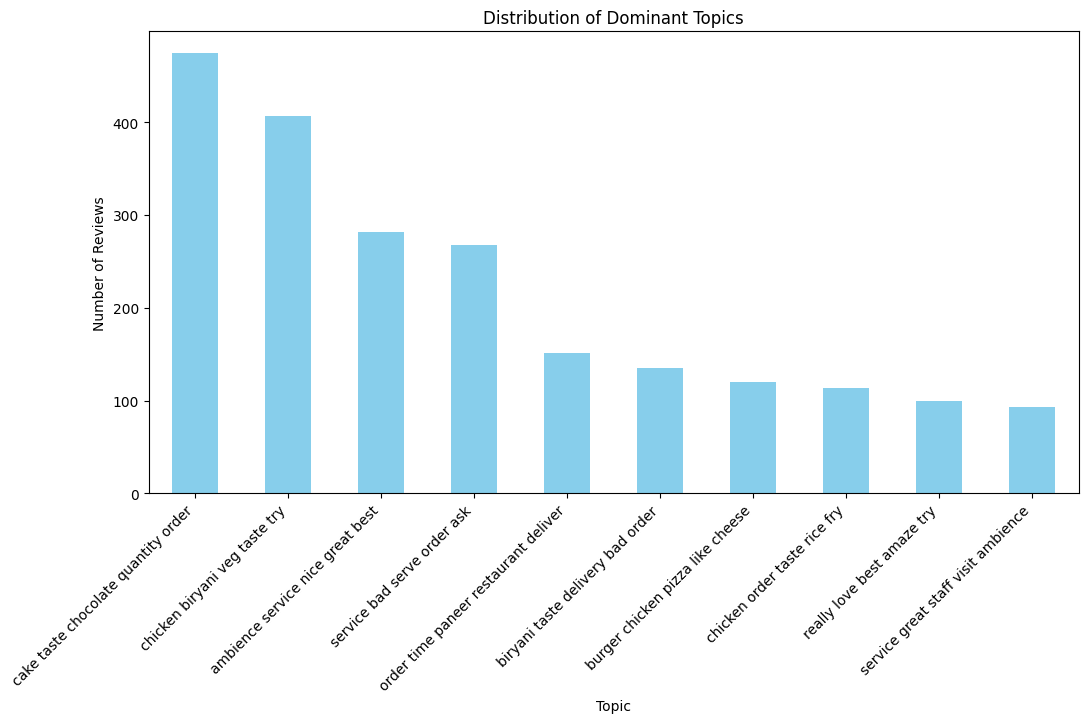

In [33]:
# Map topic numbers to names
topic_name_mapping = {idx: name for idx, name in top_words_dict.items()}
reviews['Dominant_Topic_Name'] = reviews['Dominant_Topic'].map(topic_name_mapping)

# Plot the distribution of dominant topics with topic names
topic_counts = reviews['Dominant_Topic_Name'].value_counts()
plt.figure(figsize=(12, 6))
topic_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Dominant Topics')
plt.xlabel('Topic')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45, ha='right')
plt.show()

In [34]:
# Sentiment Analysis
def get_sentiment(text):
    '''
    Computes the sentiment of a review using TextBlob
    '''
    return TextBlob(text).sentiment.polarity
reviews['Sentiment'] = reviews['Review'].apply(get_sentiment)

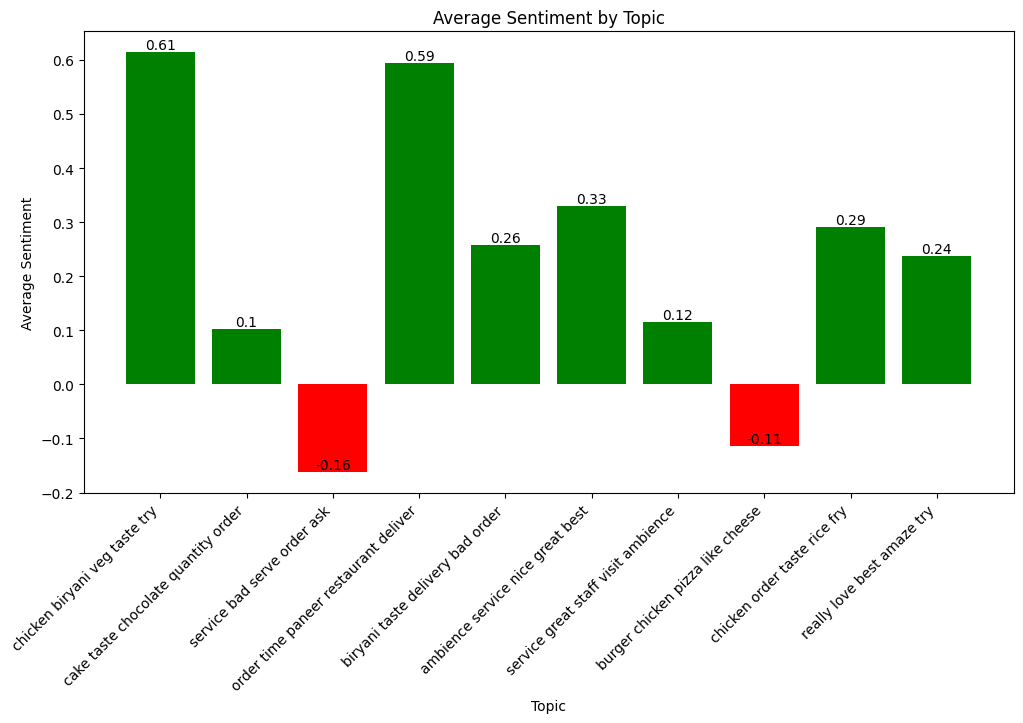

In [36]:
# Preparing data for plotting
topic_sentiment = reviews.groupby('Dominant_Topic')['Sentiment'].mean()

# Ensure all topic indices are present in top_words_dict
valid_topics = [topic for topic in topic_sentiment.index if topic in top_words_dict]

# Get topic names and sentiments for valid topics
topic_names = [top_words_dict[topic] for topic in valid_topics]
sentiments = topic_sentiment[valid_topics].values

# Defining colors based on sentiment
colors = ['green' if sentiment > 0 else 'red' if sentiment < 0 else 'grey' for sentiment in sentiments]

# Plot the sentiment by topic
plt.figure(figsize=(12, 6))
bars = plt.bar(topic_names, sentiments, color=colors)
plt.xlabel('Topic')
plt.ylabel('Average Sentiment')
plt.title('Average Sentiment by Topic')
plt.xticks(rotation=45, ha='right')

# Adding sentiment values on top center of the bars
for bar, sentiment in zip(bars, sentiments):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(sentiment, 2), ha='center', va='bottom')

plt.show()

### 4.2. Word Clouds

In [37]:
# Color words based on sentiment polarity
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    sentiment = get_sentiment(word)
    if sentiment > 0:
        return "rgb(0, 255, 0)"  # Green
    elif sentiment < 0:
        return "rgb(255, 0, 0)"  # Red
    else:
        return "rgb(128, 128, 128)"  # Grey

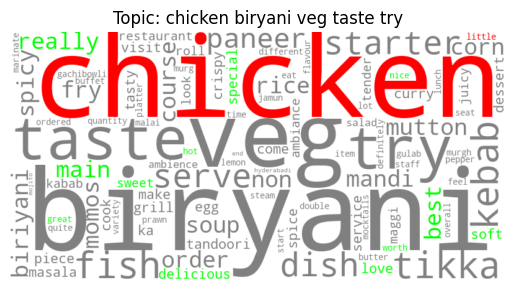

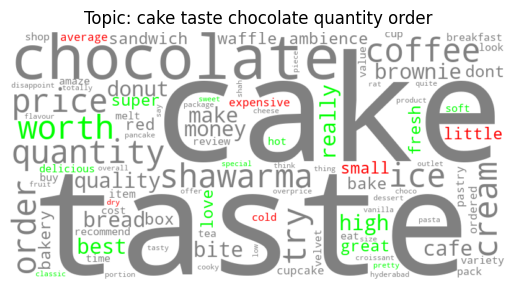

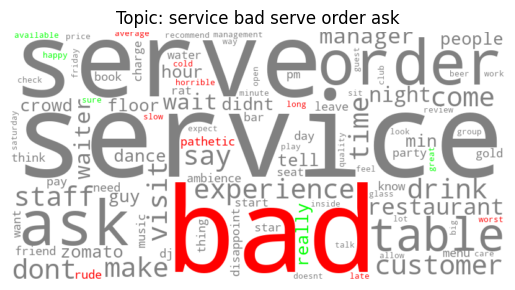

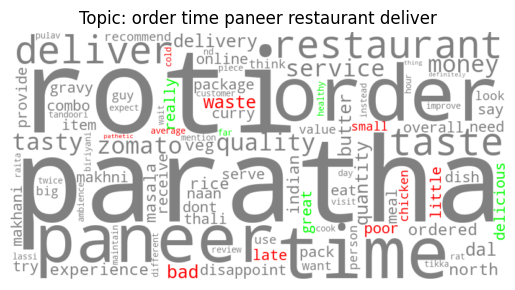

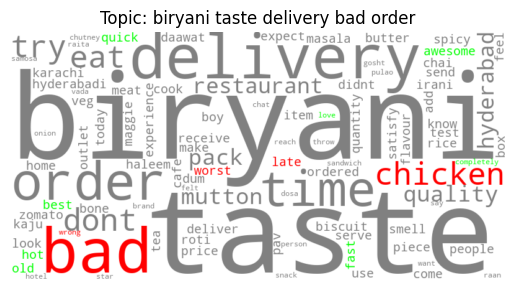

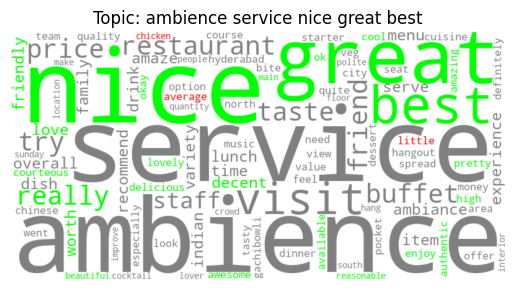

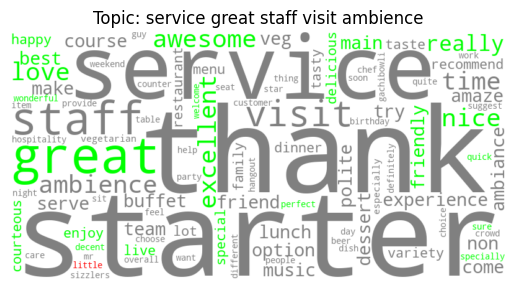

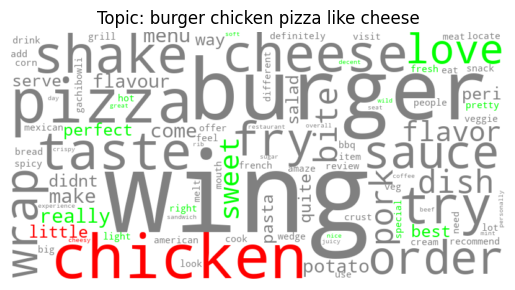

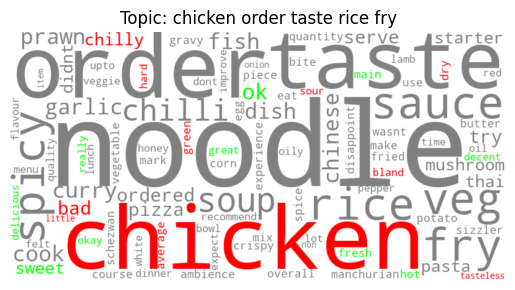

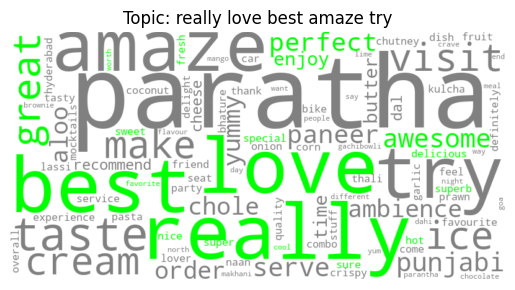

In [ ]:
# Generates word clouds for each topic
no_top_words = 100

for topic_idx, topic_name in top_words_dict.items():
    topic_words = " ".join([tf_feature_names[i] for i in lda.components_[topic_idx].argsort()[:-no_top_words - 1:-1]])
    wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=color_func).generate(topic_words)
    
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Topic: {topic_name}')
    plt.show()

### 4.3. Evolution over time

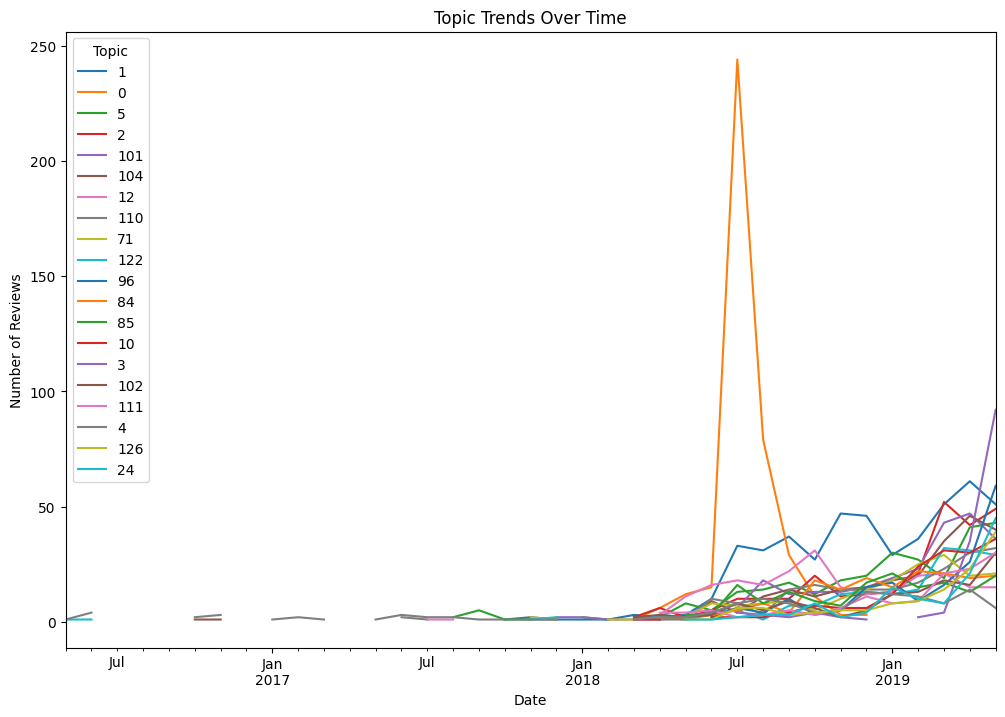

In [ ]:
reviews['Time'] = pd.to_datetime(reviews['Time'])

# Group by time period and dominant topic, then count occurrences
topic_trends = reviews.groupby([reviews['Time'].dt.to_period('M'), 'Dominant_Topic']).size().unstack()

# Identify the top 20 most common topics
top_20_topics = reviews['Dominant_Topic'].value_counts().head(20).index

# Filter the topic_trends DataFrame to include only the top 20 topics
topic_trends = topic_trends[top_20_topics]

# Check if topic_trends is not empty before plotting
topic_trends.plot(kind='line', figsize=(12, 8))
plt.title('Topic Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.legend(title='Topic')
plt.show()

### 4.4. Co-occurence

In [102]:
from itertools import combinations
from collections import Counter

def get_topic_pairs(topic_dist):
    '''
    Outputs pairs of topics with significant (>0.1) presence in a given review
    '''
    topic_dist_array = np.array(topic_dist)
    return list(combinations(np.where(topic_dist_array > 0.1)[0], 2))

# Getting topic pairs and counts
topic_pairs = reviews['Topic_Distribution'].apply(get_topic_pairs).tolist()
flat_topic_pairs = [pair for sublist in topic_pairs for pair in sublist]
topic_pair_counts = Counter(flat_topic_pairs)

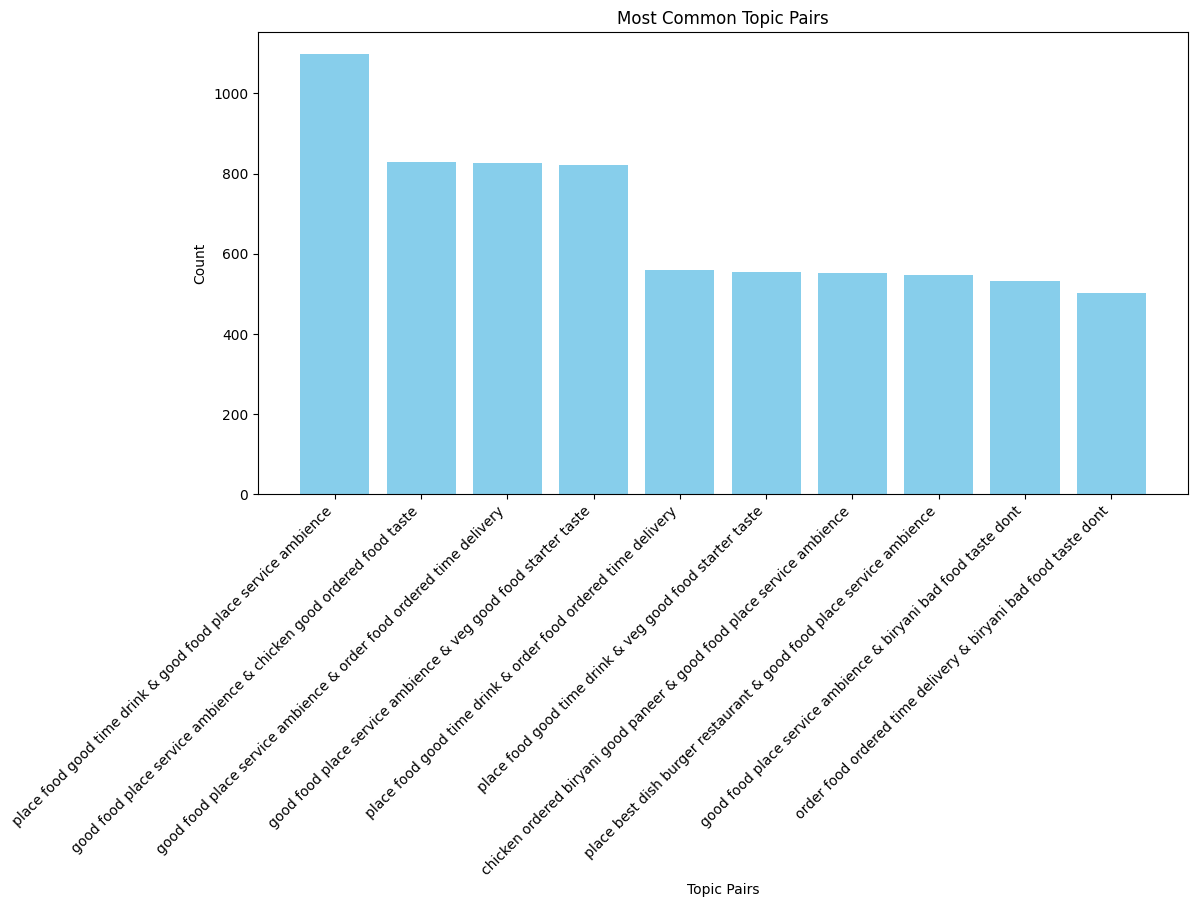

In [103]:
import numpy as np
from itertools import combinations
from collections import Counter
import matplotlib.pyplot as plt

# Preparing data for plotting
most_common_pairs = topic_pair_counts.most_common(10)
pairs, counts = zip(*most_common_pairs)
pair_labels = [f"{top_words_dict[pair[0]]} & {top_words_dict[pair[1]]}" for pair in pairs]

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(pair_labels, counts, color='skyblue')
plt.xlabel('Topic Pairs')
plt.ylabel('Count')
plt.title('Most Common Topic Pairs')
plt.xticks(rotation=45, ha='right')
plt.show()

### 4.5. Topic distribution per reviwer

In [105]:
reviewer_topic_distribution = reviews.groupby('Reviewer')['Dominant_Topic'].value_counts(normalize=True).unstack().fillna(0)
print(reviewer_topic_distribution)

Dominant_Topic                 0    1    2    3    4    5    6    7    8    9
Reviewer                                                                     
#FOODPORN                    0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
#chloesviews // CAH          0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
$ign                         0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
4mybanti                     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0
@FuloriBinaChutneyKaiseBani  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
...                          ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
ಅಭಿಷೇಕ್ ಉಪಾಧ್ಯ               0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0
ᴀɴ.ᴏᴛʜᴇʀ.sᴇɴ                 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
✌️✌️Reddy 🥂🍽️                1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
✔️ Sonu                      0.0  0.0  0.0  0.0  0.0  0.0  0.5  0.0  0.5  0.0
🍛🍲🥗                          0.0  0.0  0.0  0.0  0.0  0.0  0.5  

C:\Users\msard\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127835 (\N{CURRY AND RICE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\msard\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127858 (\N{POT OF FOOD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\msard\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 129367 (\N{GREEN SALAD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


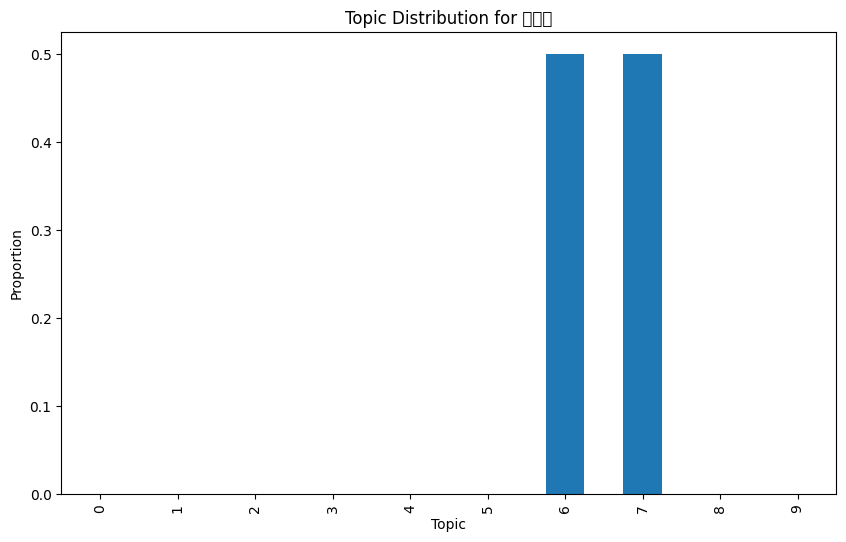

In [106]:
# Plotting topic distribution for a specific reviewer
reviewer = '🍛🍲🥗'
reviewer_topic_distribution.loc[reviewer].plot(kind='bar', figsize=(10, 6))
plt.title(f'Topic Distribution for {reviewer}')
plt.xlabel('Topic')
plt.ylabel('Proportion')
plt.show()

### 4.6. Topic correlation with rating

Dominant_Topic
0    3.712411
1    4.219753
2    3.870370
3    3.420000
4    4.487912
5    3.473799
6    2.219064
7    2.169632
8    3.342134
9    3.732406
Name: Rating, dtype: float64


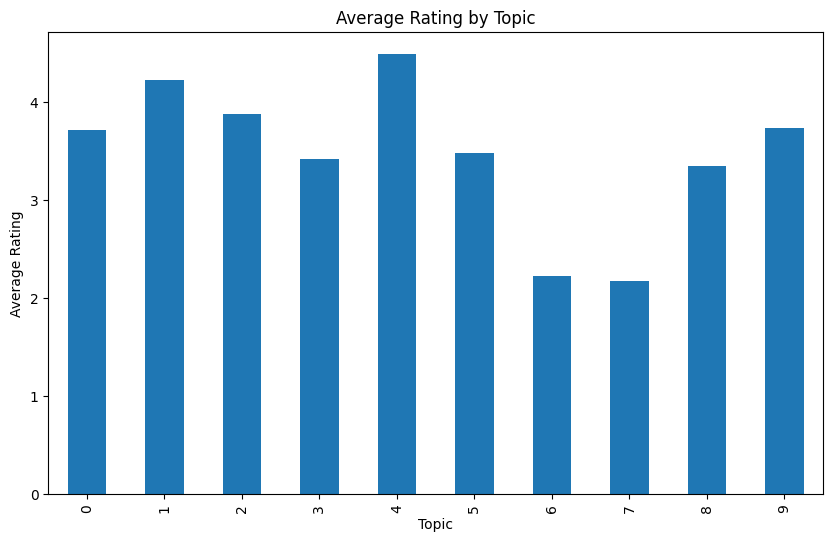

In [ ]:
# Preprocessing
reviews['Rating'] = pd.to_numeric(reviews['Rating'], errors='coerce')
reviews = reviews.dropna(subset=['Rating'])

topic_ratings = reviews.groupby('Dominant_Topic')['Rating'].mean()

# Plotting
topic_ratings.plot(kind='bar', figsize=(10, 6))
plt.title('Average Rating by Topic')
plt.xlabel('Topic')
plt.ylabel('Average Rating')
plt.show()

### 4.7. Impact of pictures

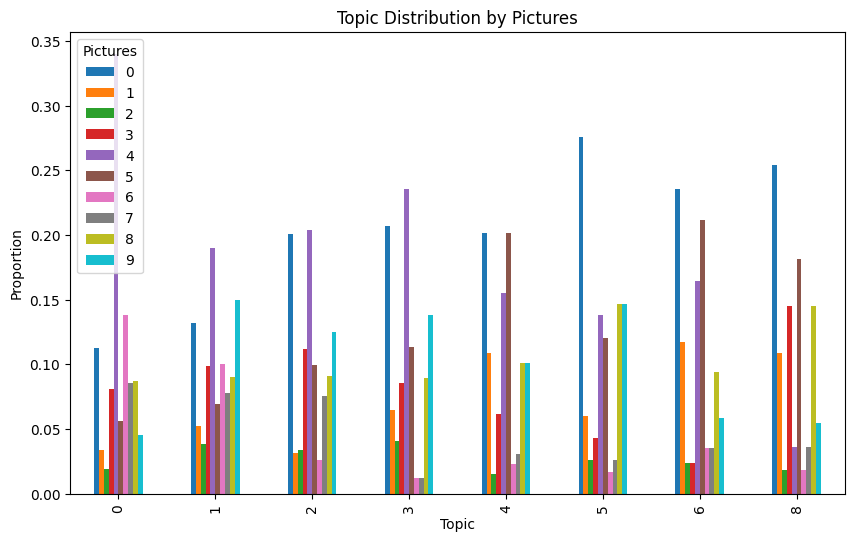

In [109]:
picture_topic_distribution = reviews.groupby('Pictures')['Dominant_Topic'].value_counts(normalize=True).unstack().dropna()

# Plot the topic distribution for reviews with and without pictures
picture_topic_distribution.plot(kind='bar', figsize=(10, 6))
plt.title('Topic Distribution by Pictures')
plt.xlabel('Topic')
plt.ylabel('Proportion')
plt.legend(title='Pictures')
plt.show()